In [2]:
import os
import glob
import cv2
import numpy as np
import random
import json
import matplotlib.pyplot as plt
from create_dataset_utils import *
import torch
from PIL import Image

Tạo dataset

In [ ]:
# Define directory paths
vid_folder = r'C:\Users\phann\Documents\Pig_farming\dataset\Edinburgh_Pig_Behavior_Video_Dataset\video'  # Contains subfolders like "2019-11-22--11_20_15"
track_folder = r'C:\Users\phann\Documents\Pig_farming\dataset\Edinburgh_Pig_Behavior_Video_Dataset\results_dataset'       # Contains corresponding track subfolders
output_dir = r'C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\scale_count'           # Where processed outputs will be saved

# Create output directories
images_output_dir = os.path.join(output_dir, "images")
density_maps_output_dir = os.path.join(output_dir, "gt_density_maps")
os.makedirs(images_output_dir, exist_ok=True)
os.makedirs(density_maps_output_dir, exist_ok=True)

# Initialize a global frame counter based on existing images
existing_images = glob.glob(os.path.join(images_output_dir, "*.jpg"))
existing_numbers = [
    int(os.path.basename(f).split('_')[0])
    for f in existing_images
    if os.path.basename(f).split('_')[0].isdigit()
]
global_frame_counter = max(existing_numbers) + 1 if existing_numbers else 1

# Define annotation file path and load existing annotations if available
annotation_file = os.path.join(output_dir, "annotation.json")
if os.path.exists(annotation_file):
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
else:
    annotations = {}

# Process all date-time subfolders
date_dirs = sorted(glob.glob(os.path.join(vid_folder, "*")))
for date_dir in date_dirs:
    date_id = os.path.basename(date_dir)  # e.g., "2019-11-22--11_20_15"
    # Find numbered subfolders (e.g., "0001", "0002")
    numbered_dirs = sorted(glob.glob(os.path.join(date_dir, "*")))
    
    for numbered_dir in numbered_dirs:
        if not os.path.isdir(numbered_dir):
            continue
        numbered_id = os.path.basename(numbered_dir)  # e.g., "0001"
        
        # Look for the video file in the numbered subfolder
        video_files = glob.glob(os.path.join(numbered_dir, "color.mp4"))
        if not video_files:
            print(f"No video file found in {numbered_dir}")
            continue
        video_file = video_files[0]
        
        # Find the corresponding track file
        track_subdir = os.path.join(track_folder, date_id, numbered_id)
        track_files = glob.glob(os.path.join(track_subdir, "behaviour_15.npy"))
        if not track_files:
            print(f"No track file found in {track_subdir}")
            continue
        track_file = track_files[0]
        
        # Process the video and track files (assuming create_dataset_for_video is defined elsewhere)
        global_frame_counter, annotations = create_dataset_for_video(
            video_file, track_file, images_output_dir, density_maps_output_dir,
            annotations, f"{date_id}_{numbered_id}", global_frame_counter, scales=[None, 0.45, 0.55]
        )

# Save merged annotations
with open(annotation_file, 'w') as f:
    json.dump(annotations, f, indent=4)

print("Processing complete!")


Processed image 003601_original.jpg from video 2019-12-07--16_44_18_000151 (frame 0)
Processed image 003601_scale045.jpg from video 2019-12-07--16_44_18_000151 (frame 0)
Processed image 003601_scale055.jpg from video 2019-12-07--16_44_18_000151 (frame 0)
Processed image 003602_original.jpg from video 2019-12-07--16_44_18_000151 (frame 199)
Processed image 003602_scale045.jpg from video 2019-12-07--16_44_18_000151 (frame 199)
Processed image 003602_scale055.jpg from video 2019-12-07--16_44_18_000151 (frame 199)
Processed image 003603_original.jpg from video 2019-12-07--16_44_18_000151 (frame 399)
Processed image 003603_scale045.jpg from video 2019-12-07--16_44_18_000151 (frame 399)
Processed image 003603_scale055.jpg from video 2019-12-07--16_44_18_000151 (frame 399)
Processed image 003604_original.jpg from video 2019-12-07--16_44_18_000151 (frame 599)
Processed image 003604_scale045.jpg from video 2019-12-07--16_44_18_000151 (frame 599)
Processed image 003604_scale055.jpg from video 20

Tạo file json train_val_test spilt

In [3]:
output_dir = r'C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\scale_count'
images_output_dir= r'C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\scale_count\images'
os.makedirs(output_dir, exist_ok=True)
create_data_split(images_output_dir, output_dir)

Data split saved to C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\scale_count\data_split.json


Kiểm tra Dataset

Density map shape: (720, 1280), Sum: 9.000000953674316


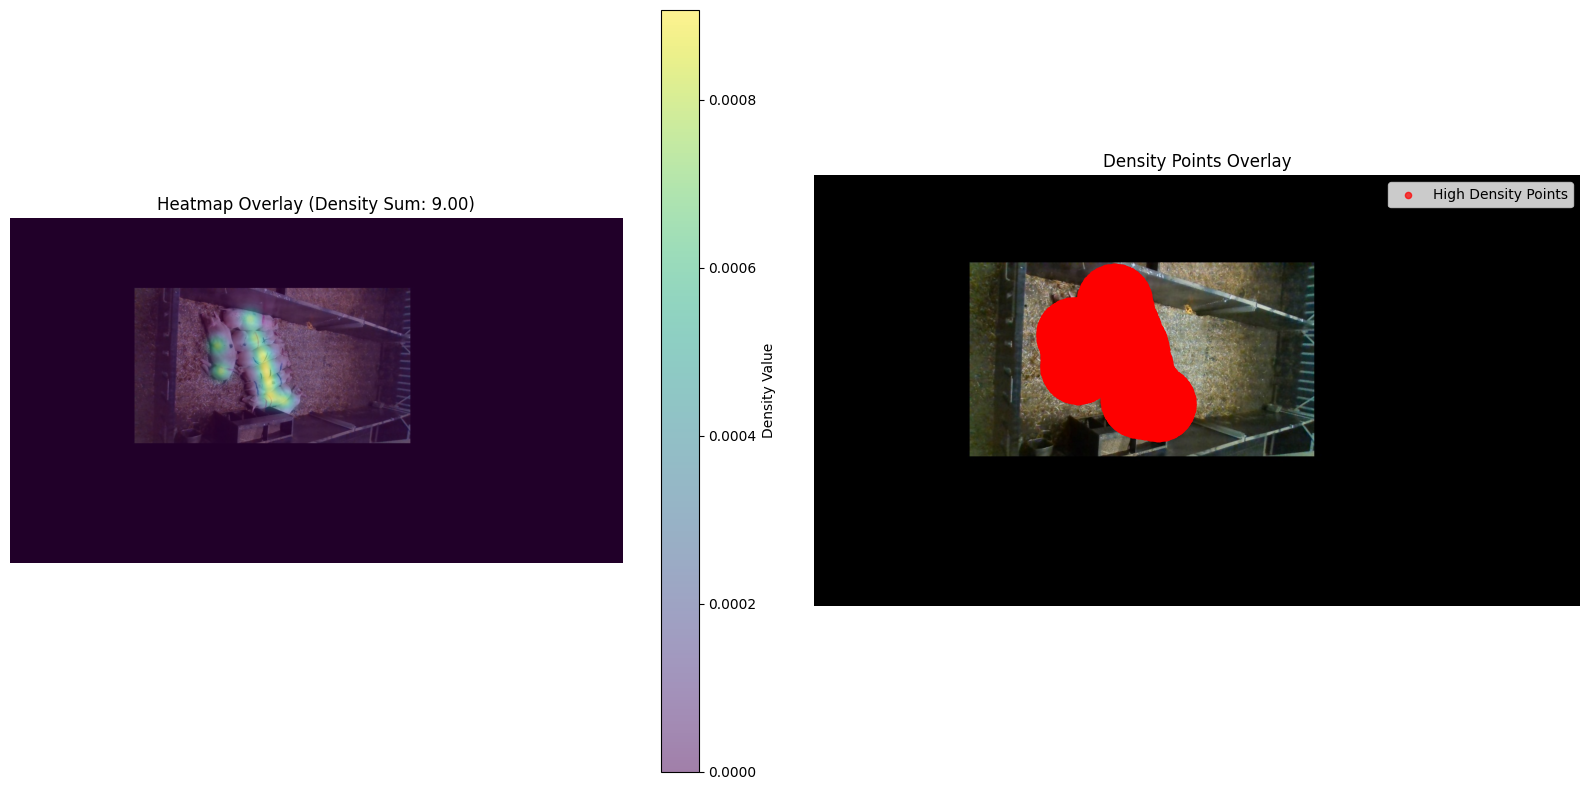

Overlay visualization saved as 'density_overlay_combined.png'


In [9]:
#load density map
density_path = r'C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\output_frame\55\gt_density_maps\3.npy'
density = np.load(density_path).astype('float32')

if density is None or density.size == 0:
    print("Error: Loaded density map is empty!")
else:
    print(f"Density map shape: {density.shape}, Sum: {density.sum()}")

density_tensor = torch.tensor(density, dtype=torch.float32)

#load image
real_image_path = r'C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\output_frame\55\images\3.jpg'
real_image = plt.imread(real_image_path)

# kiểm tra size
if real_image.shape[:2] != density.shape:
    print("Warning: Real image and density map dimensions do not match. Resizing density map to match real image dimensions.")
    # Convert density to a PIL image and resize it
    density_img = Image.fromarray(density)
    density_resized = np.array(density_img.resize((real_image.shape[1], real_image.shape[0]), Image.BILINEAR))
else:
    density_resized = density

#Visual 
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# 1. Heatmap Overlay
ax[0].imshow(real_image, cmap='gray')
heatmap = ax[0].imshow(density_resized, cmap='viridis', alpha=0.5)
fig.colorbar(heatmap, ax=ax[0], label="Density Value")
ax[0].set_title(f"Heatmap Overlay (Density Sum: {density_tensor.sum():.2f})")
ax[0].axis('off')

# 2. Density Points Overlay
threshold = np.percentile(density_resized, 95)
points = np.argwhere(density_resized > threshold)
x_coords = points[:, 1]
y_coords = points[:, 0]
ax[1].imshow(real_image, cmap='gray')
ax[1].scatter(x_coords, y_coords, color='red', s=20, alpha=0.7, label='High Density Points')
ax[1].set_title("Density Points Overlay")
ax[1].legend()
ax[1].axis('off')

plt.tight_layout()
plt.savefig("density_overlay_combined.png", dpi=300, bbox_inches='tight')
plt.show()

print("Overlay visualization saved as 'density_overlay_combined.png'")


In [ ]:
import os
import json
import cv2
import numpy as np

# Đường dẫn đến file JSON và thư mục chứa ảnh
json_path = r"C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\annotation.json"  # Đổi thành đường dẫn file JSON của bạn
image_folder = r"C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\scale_count\images"  # Đổi thành thư mục chứa ảnh của bạn
output = r"C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\viz_points"
if not os.path.exists(output):
    os.makedirs(output)
# Đọc file JSON
with open(json_path, "r") as f:
    data = json.load(f)

# Duyệt qua từng ảnh trong JSON
for image_name, annotations in data.items():
    image_path = os.path.join(image_folder, image_name)
    
    # Kiểm tra nếu ảnh tồn tại
    if not os.path.exists(image_path):
        print(f"Không tìm thấy ảnh: {image_path}")
        continue
    
    # Đọc ảnh
    image = cv2.imread(image_path)
    
    # Vẽ box_examples_coordinates (Hình chữ nhật)
    for box in annotations.get("box_examples_coordinates", []):
        pts = np.array(box, dtype=np.int32)  # Chuyển đổi sang numpy array
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Vẽ các points (Điểm riêng lẻ)
    for point in annotations.get("points", []):
        x, y = int(point[0]), int(point[1])
        cv2.circle(image, (x, y), radius=5, color=(0, 0, 255), thickness=-1)
    
    # save ảnh đã vẽ
    output_path = os.path.join(output, image_name)
    print(output_path)
    cv2.imwrite(output_path, image)

In [3]:
import json

# Path to your annotation file
annotation_file = r'C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\scale_count\annotation.json'

# Load the annotation file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# List to store keys with missing "points"
missing_points = []

# Check each annotation entry for the "points" key
for key, value in annotations.items():
    if "points" not in value or not value["points"]:
        missing_points.append(key)

# Report the findings
if missing_points:
    print("The following annotation entries do not have 'points':")
    for key in missing_points:
        print(f"Key: {key}, Data: {annotations[key]}")
else:
    print("All annotation entries have 'points'.")


The following annotation entries do not have 'points':
Key: 000066_original.jpg, Data: {'H': 720, 'W': 1280, 'box_examples_coordinates': [], 'points': []}
Key: 000066_scale045.jpg, Data: {'H': 720, 'W': 1280, 'box_examples_coordinates': [], 'points': []}
Key: 000066_scale055.jpg, Data: {'H': 720, 'W': 1280, 'box_examples_coordinates': [], 'points': []}
Key: 000067_original.jpg, Data: {'H': 720, 'W': 1280, 'box_examples_coordinates': [], 'points': []}
Key: 000067_scale045.jpg, Data: {'H': 720, 'W': 1280, 'box_examples_coordinates': [], 'points': []}
Key: 000067_scale055.jpg, Data: {'H': 720, 'W': 1280, 'box_examples_coordinates': [], 'points': []}
Key: 000069_original.jpg, Data: {'H': 720, 'W': 1280, 'box_examples_coordinates': [], 'points': []}
Key: 000069_scale045.jpg, Data: {'H': 720, 'W': 1280, 'box_examples_coordinates': [], 'points': []}
Key: 000069_scale055.jpg, Data: {'H': 720, 'W': 1280, 'box_examples_coordinates': [], 'points': []}
Key: 000070_original.jpg, Data: {'H': 720, 'W